# Imports

In [27]:
from google.cloud import bigquery
import pandas as pd
from pandas_profiling import ProfileReport
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import math
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

# Reading Queries

In [14]:
%cd ..

/home/bhanu.mittal/Github/PDSA/Python/scripts/Product Metric Monitoring


In [18]:
total_signups_query = open('Data Scheduler/Queries/total_signups_query.sql', 'r').read()
signup_completed_query = open('Data Scheduler/Queries/signup_completed_query.sql', 'r').read()
devs_vetted_query = open('Data Scheduler/Queries/devs_vetted_query.sql', 'r').read()
devs_shortlisted_query = open('Data Scheduler/Queries/devs_shortlisted_query.sql', 'r').read()

# Useful Functions

In [28]:
def query_result(query):
    client = bigquery.Client('turing-230020')
    output = client.query(query).to_dataframe()
    client.close()
    return output

def data_preprocess(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df = df[df['date'] >= '2019-09-01']

    date_range = pd.date_range(df['date'].min(), df['date'].max())

    df = df.set_index('date')
    df = df.reindex(date_range, fill_value=0)
    df = df.reset_index()
    df.columns = ['ds', 'y']
    df['ds'] = df['ds'].dt.tz_localize(None)
    df['mean'] = df['y'].rolling(window=7).mean()
    
    return df

def train_test_split(data):
    timestamp = total_signups.loc[round (total_signups.shape[0] * 95/100)]['ds']
    
    train, test = total_signups[total_signups['ds'] < timestamp], total_signups[total_signups['ds'] >= timestamp]
    
    return train, test

def call_prophet(data):
    global_yearly_seasonality = True
    global_weekly_seasonality = True
    global_daily_seasonality = True
    global_holiday_effect = True
    global_seasonality_mode = 'additive'
    global_interval_width = 0.8
    global_performance_RMSE = float('inf')
    global_n_changepoints = 25
    global_changepoint_prior_scale = 0.05
    
    for yearly_seasonality in [False, True]:
        for weekly_seasonality in [False, True]:
            for daily_seasonality in [False, True]:
                for seasonality_mode in ['additive', 'multiplicative']:
                    for interval_width in [0.95, 0.99]:
                        for holiday_effect in [False, True]:
                            for n_changepoints in [25, 50, 100, 150, 200]:
                                for changepoint_prior_scale in [0.01, 0.025, 0.05, 0.075, 0.1]:
    
                                    model = Prophet(daily_seasonality=daily_seasonality, yearly_seasonality=yearly_seasonality
                                                    , weekly_seasonality=weekly_seasonality, seasonality_mode=seasonality_mode
                                                    , interval_width=interval_width, changepoint_range=0.8, n_changepoints=n_changepoints
                                                    , changepoint_prior_scale=changepoint_prior_scale)

                                    if holiday_effect:
                                        model.add_country_holidays(country_name='US')

                                    today = datetime.date.today()
                                    week_ago = pd.to_datetime(today - datetime.timedelta(days=7), format='%Y-%m-%d')

                                    model.fit(data[data['ds'] < week_ago])
                                    forecast = model.predict(data[data['ds'] >= week_ago])

                                    performance = pd.merge(data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

                                    performance_MSE = mean_squared_error(performance['y'], performance['yhat'])
                                    performance_RMSE = math.sqrt(performance_MSE)
                            
                                    if performance_RMSE < global_performance_RMSE:
                                
                                        print('New:')
                                        print("Daily Seasonality:", daily_seasonality)
                                        print("Weekly Seasonality:", weekly_seasonality)
                                        print("Yearly Seasonality:", yearly_seasonality)
                                        print("Holiday Effect:", holiday_effect)
                                        print("Seasonality Mode:", seasonality_mode)
                                        print("Interval Width:", interval_width)
                                        print("No. of changepoints:", n_changepoints)
                                        print("Changepoint Prior:", changepoint_prior_scale)
                                
                                        print(global_performance_RMSE, performance_RMSE)
                                
                                        global_yearly_seasonality = yearly_seasonality
                                        global_weekly_seasonality = weekly_seasonality
                                        global_daily_seasonality = daily_seasonality
                                        global_seasonality_mode = seasonality_mode
                                        global_interval_width = interval_width
                                        global_holiday_effect = holiday_effect
                                        global_performance_RMSE = performance_RMSE
                                        global_n_changepoints = n_changepoints
                                        global_changepoint_prior_scale = changepoint_prior_scale

    print("Daily Seasonality:", global_daily_seasonality)
    print("Weekly Seasonality:", global_weekly_seasonality)
    print("Yearly Seasonality:", global_yearly_seasonality)
    print("Holiday Effect:", global_holiday_effect)
    print("Seasonality Mode:", global_seasonality_mode)
    print("Interval Width:", global_interval_width)
    print("No. of changepoints:", global_n_changepoints)
    print("Changepoint Prior:", global_changepoint_prior_scale)
    model = Prophet(daily_seasonality=global_daily_seasonality, yearly_seasonality=global_yearly_seasonality
                    , weekly_seasonality=global_weekly_seasonality, seasonality_mode=global_seasonality_mode
                    , interval_width=global_interval_width, changepoint_range=0.8, n_changepoints=global_n_changepoints
                    , changepoint_prior_scale=global_changepoint_prior_scale)
    
    if global_holiday_effect:
        model.add_country_holidays(country_name='US')

    model.fit(data)
    forecast = model.predict(data)
                
    performance = pd.merge(data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
    performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)
    print(performance['anomaly'].value_counts())

    performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
    print(f'The MAE for the model is {performance_MAE}')

    performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
    print(f'The MAPE for the model is {performance_MAPE}')
    
    performance_MSE = mean_squared_error(performance['y'], performance['yhat'])
    performance_RMSE = math.sqrt(performance_MSE)
    print(f'The RMSE for the model is {performance_RMSE}')
    
    model.plot(forecast)
    model.plot_components(forecast)
                
    anomalies = performance[performance['anomaly']==1].sort_values(by='ds')
    anomalies['day_name'] = (anomalies['ds'].dt.day_name()).values
    
    return anomalies

In [40]:
def query_result(query):
    client = bigquery.Client('turing-230020')
    output = client.query(query).to_dataframe()
    client.close()
    return output

def data_preprocess(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df = df[df['date'] >= '2019-09-01']

    date_range = pd.date_range(df['date'].min(), df['date'].max())

    df = df.set_index('date')
    df = df.reindex(date_range, fill_value=0)
    df = df.reset_index()
    df.columns = ['ds', 'y']
    df['ds'] = df['ds'].dt.tz_localize(None)
    df['mean'] = df['y'].rolling(window=7).mean()
    
    return df

def train_test_split(data):
    timestamp = total_signups.loc[round (total_signups.shape[0] * 95/100)]['ds']
    
    train, test = total_signups[total_signups['ds'] < timestamp], total_signups[total_signups['ds'] >= timestamp]
    
    return train, test

def call_prophet(data):
    global_yearly_seasonality = True
    global_weekly_seasonality = True
    global_daily_seasonality = True
    global_holiday_effect = True
    global_seasonality_mode = 'additive'
    global_interval_width = 0.8
    global_performance_RMSE = float('inf')
    global_n_changepoints = 25
    global_changepoint_prior_scale = 0.05
    
    for yearly_seasonality in [True]:
        for weekly_seasonality in [True]:
            for daily_seasonality in [False]:
                for seasonality_mode in ['multiplicative']:
                    for interval_width in [0.95]:
                        for holiday_effect in [True]:
                            for n_changepoints in [25, 50, 100, 150, 200]:
                                for changepoint_prior_scale in [0.001, 0.006, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5]:
    
                                    model = Prophet(daily_seasonality=daily_seasonality, yearly_seasonality=yearly_seasonality
                                                    , weekly_seasonality=weekly_seasonality, seasonality_mode=seasonality_mode
                                                    , interval_width=interval_width, changepoint_range=0.8, n_changepoints=n_changepoints
                                                    , changepoint_prior_scale=changepoint_prior_scale)

                                    if holiday_effect:
                                        model.add_country_holidays(country_name='US')

                                    today = datetime.date.today()
                                    week_ago = pd.to_datetime(today - datetime.timedelta(days=7), format='%Y-%m-%d')

                                    model.fit(data[data['ds'] < week_ago])
                                    forecast = model.predict(data)

                                    performance = pd.merge(data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

                                    performance_MSE = mean_squared_error(performance['y'], performance['yhat'])
                                    performance_RMSE = math.sqrt(performance_MSE)
                            
                                    if performance_RMSE < global_performance_RMSE:
                                
                                        print('New:')
                                        print("Daily Seasonality:", daily_seasonality)
                                        print("Weekly Seasonality:", weekly_seasonality)
                                        print("Yearly Seasonality:", yearly_seasonality)
                                        print("Holiday Effect:", holiday_effect)
                                        print("Seasonality Mode:", seasonality_mode)
                                        print("Interval Width:", interval_width)
                                        print("No. of changepoints:", n_changepoints)
                                        print("Changepoint Prior:", changepoint_prior_scale)
                                
                                        print(global_performance_RMSE, performance_RMSE)
                                
                                        global_yearly_seasonality = yearly_seasonality
                                        global_weekly_seasonality = weekly_seasonality
                                        global_daily_seasonality = daily_seasonality
                                        global_seasonality_mode = seasonality_mode
                                        global_interval_width = interval_width
                                        global_holiday_effect = holiday_effect
                                        global_performance_RMSE = performance_RMSE
                                        global_n_changepoints = n_changepoints
                                        global_changepoint_prior_scale = changepoint_prior_scale

    print("Daily Seasonality:", global_daily_seasonality)
    print("Weekly Seasonality:", global_weekly_seasonality)
    print("Yearly Seasonality:", global_yearly_seasonality)
    print("Holiday Effect:", global_holiday_effect)
    print("Seasonality Mode:", global_seasonality_mode)
    print("Interval Width:", global_interval_width)
    print("No. of changepoints:", global_n_changepoints)
    print("Changepoint Prior:", global_changepoint_prior_scale)
    model = Prophet(daily_seasonality=global_daily_seasonality, yearly_seasonality=global_yearly_seasonality
                    , weekly_seasonality=global_weekly_seasonality, seasonality_mode=global_seasonality_mode
                    , interval_width=global_interval_width, changepoint_range=0.8, n_changepoints=global_n_changepoints
                    , changepoint_prior_scale=global_changepoint_prior_scale)
    
    if global_holiday_effect:
        model.add_country_holidays(country_name='US')

    model.fit(data[data['ds'] < week_ago])
    forecast = model.predict(data)
                
    performance = pd.merge(data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
    performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)
    print(performance['anomaly'].value_counts())

    performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
    print(f'The MAE for the model is {performance_MAE}')

    performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
    print(f'The MAPE for the model is {performance_MAPE}')
    
    performance_MSE = mean_squared_error(performance['y'], performance['yhat'])
    performance_RMSE = math.sqrt(performance_MSE)
    print(f'The RMSE for the model is {performance_RMSE}')
    
    model.plot(forecast)
    model.plot_components(forecast)
                
    anomalies = performance[performance['anomaly']==1].sort_values(by='ds')
    anomalies['day_name'] = (anomalies['ds'].dt.day_name()).values
    
    return anomalies

# Data

In [41]:
total_signups = query_result(total_signups_query.format('LATAM'))
total_signups = data_preprocess(total_signups)

signup_completed = query_result(signup_completed_query.format('LATAM'))
signup_completed = data_preprocess(signup_completed)

devs_vetted = query_result(devs_vetted_query.format('LATAM'))
devs_vetted = data_preprocess(devs_vetted)

devs_shortlisted = query_result(devs_shortlisted_query.format('Platinum', 'existing'))
devs_shortlisted = data_preprocess(devs_shortlisted)

# Prophet

In [42]:
data = total_signups

anomalies = call_prophet(data)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(anomalies)

18:34:05 - cmdstanpy - INFO - Chain [1] start processing
18:34:05 - cmdstanpy - INFO - Chain [1] done processing
18:34:13 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 25
Changepoint Prior: 0.001
inf 116.64587575091207


18:34:13 - cmdstanpy - INFO - Chain [1] done processing
18:34:22 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 25
Changepoint Prior: 0.006
116.64587575091207 96.33788580395684


18:34:22 - cmdstanpy - INFO - Chain [1] done processing
18:34:31 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 25
Changepoint Prior: 0.01
96.33788580395684 95.2744543597689


18:34:32 - cmdstanpy - INFO - Chain [1] done processing
18:34:40 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 25
Changepoint Prior: 0.025
95.2744543597689 93.33270138748989


18:34:40 - cmdstanpy - INFO - Chain [1] done processing
18:34:49 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 25
Changepoint Prior: 0.05
93.33270138748989 91.86999610637938


18:34:50 - cmdstanpy - INFO - Chain [1] done processing
18:34:58 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 25
Changepoint Prior: 0.075
91.86999610637938 91.49659080589954


18:34:58 - cmdstanpy - INFO - Chain [1] done processing
18:35:07 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 25
Changepoint Prior: 0.1
91.49659080589954 91.39247081507624


18:35:08 - cmdstanpy - INFO - Chain [1] done processing
18:35:17 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 25
Changepoint Prior: 0.25
91.39247081507624 89.87193337454644


18:35:18 - cmdstanpy - INFO - Chain [1] done processing
18:35:27 - cmdstanpy - INFO - Chain [1] start processing
18:35:27 - cmdstanpy - INFO - Chain [1] done processing
18:35:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
18:35:27 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 25
Changepoint Prior: 0.5
89.87193337454644 87.57913845533844


18:35:44 - cmdstanpy - INFO - Chain [1] done processing
18:35:55 - cmdstanpy - INFO - Chain [1] start processing
18:35:55 - cmdstanpy - INFO - Chain [1] done processing
18:36:07 - cmdstanpy - INFO - Chain [1] start processing
18:36:07 - cmdstanpy - INFO - Chain [1] done processing
18:36:18 - cmdstanpy - INFO - Chain [1] start processing
18:36:18 - cmdstanpy - INFO - Chain [1] done processing
18:36:29 - cmdstanpy - INFO - Chain [1] start processing
18:36:30 - cmdstanpy - INFO - Chain [1] done processing
18:36:40 - cmdstanpy - INFO - Chain [1] start processing
18:36:40 - cmdstanpy - INFO - Chain [1] done processing
18:36:49 - cmdstanpy - INFO - Chain [1] start processing
18:36:49 - cmdstanpy - INFO - Chain [1] done processing
18:36:58 - cmdstanpy - INFO - Chain [1] start processing
18:36:58 - cmdstanpy - INFO - Chain [1] done processing
18:37:07 - cmdstanpy - INFO - Chain [1] start processing
18:37:08 - cmdstanpy - INFO - Chain [1] done processing
18:37:17 - cmdstanpy - INFO - Chain [1] 

KeyboardInterrupt: 

In [ ]:
data = signup_completed

anomalies = call_prophet(data)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(anomalies)

18:15:56 - cmdstanpy - INFO - Chain [1] start processing
18:15:56 - cmdstanpy - INFO - Chain [1] done processing
18:15:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
18:15:56 - cmdstanpy - INFO - Chain [1] start processing
18:15:58 - cmdstanpy - INFO - Chain [1] done processing
18:15:59 - cmdstanpy - INFO - Chain [1] start processing
18:15:59 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 25
Changepoint Prior: 0.001
inf 42.306021533911604


18:16:00 - cmdstanpy - INFO - Chain [1] start processing
18:16:01 - cmdstanpy - INFO - Chain [1] done processing
18:16:02 - cmdstanpy - INFO - Chain [1] start processing
18:16:02 - cmdstanpy - INFO - Chain [1] done processing
18:16:03 - cmdstanpy - INFO - Chain [1] start processing
18:16:04 - cmdstanpy - INFO - Chain [1] done processing
18:16:05 - cmdstanpy - INFO - Chain [1] start processing
18:16:05 - cmdstanpy - INFO - Chain [1] done processing
18:16:07 - cmdstanpy - INFO - Chain [1] start processing
18:16:07 - cmdstanpy - INFO - Chain [1] done processing
18:16:08 - cmdstanpy - INFO - Chain [1] start processing
18:16:08 - cmdstanpy - INFO - Chain [1] done processing
18:16:10 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 25
Changepoint Prior: 0.25
42.306021533911604 38.38544439550567


18:16:10 - cmdstanpy - INFO - Chain [1] done processing
18:16:11 - cmdstanpy - INFO - Chain [1] start processing
18:16:11 - cmdstanpy - INFO - Chain [1] done processing
18:16:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
18:16:11 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 25
Changepoint Prior: 0.5
38.38544439550567 33.59688126529138


18:16:14 - cmdstanpy - INFO - Chain [1] done processing
18:16:15 - cmdstanpy - INFO - Chain [1] start processing
18:16:15 - cmdstanpy - INFO - Chain [1] done processing
18:16:17 - cmdstanpy - INFO - Chain [1] start processing
18:16:17 - cmdstanpy - INFO - Chain [1] done processing
18:16:19 - cmdstanpy - INFO - Chain [1] start processing
18:16:19 - cmdstanpy - INFO - Chain [1] done processing
18:16:20 - cmdstanpy - INFO - Chain [1] start processing
18:16:21 - cmdstanpy - INFO - Chain [1] done processing
18:16:22 - cmdstanpy - INFO - Chain [1] start processing
18:16:22 - cmdstanpy - INFO - Chain [1] done processing
18:16:24 - cmdstanpy - INFO - Chain [1] start processing
18:16:24 - cmdstanpy - INFO - Chain [1] done processing
18:16:26 - cmdstanpy - INFO - Chain [1] start processing
18:16:26 - cmdstanpy - INFO - Chain [1] done processing
18:16:27 - cmdstanpy - INFO - Chain [1] start processing
18:16:28 - cmdstanpy - INFO - Chain [1] done processing
18:16:29 - cmdstanpy - INFO - Chain [1] 

New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 100
Changepoint Prior: 0.5
33.59688126529138 33.355656343106396


KeyboardInterrupt: 

17:58:47 - cmdstanpy - INFO - Chain [1] start processing
17:58:47 - cmdstanpy - INFO - Chain [1] done processing
17:58:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
17:58:47 - cmdstanpy - INFO - Chain [1] start processing
17:58:53 - cmdstanpy - INFO - Chain [1] done processing
17:58:55 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 25
Changepoint Prior: 0.001
inf 39.029023274792806


17:58:55 - cmdstanpy - INFO - Chain [1] done processing
17:58:56 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 25
Changepoint Prior: 0.006
39.029023274792806 33.15736885283518


17:58:57 - cmdstanpy - INFO - Chain [1] done processing
17:58:58 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 25
Changepoint Prior: 0.01
33.15736885283518 33.133038757433326


17:58:58 - cmdstanpy - INFO - Chain [1] done processing
17:59:00 - cmdstanpy - INFO - Chain [1] start processing
17:59:00 - cmdstanpy - INFO - Chain [1] done processing
17:59:02 - cmdstanpy - INFO - Chain [1] start processing
17:59:02 - cmdstanpy - INFO - Chain [1] done processing
17:59:03 - cmdstanpy - INFO - Chain [1] start processing
17:59:04 - cmdstanpy - INFO - Chain [1] done processing
17:59:05 - cmdstanpy - INFO - Chain [1] start processing
17:59:05 - cmdstanpy - INFO - Chain [1] done processing
17:59:07 - cmdstanpy - INFO - Chain [1] start processing
17:59:07 - cmdstanpy - INFO - Chain [1] done processing
17:59:09 - cmdstanpy - INFO - Chain [1] start processing
17:59:09 - cmdstanpy - INFO - Chain [1] done processing
17:59:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
17:59:09 - cmdstanpy - INFO - Chain [1] start processing
17:59:22 - cmdstanpy - INFO - Chain [1] done proc

New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 50
Changepoint Prior: 0.006
33.133038757433326 33.009154458174585


17:59:26 - cmdstanpy - INFO - Chain [1] done processing
17:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1] done processing
17:59:30 - cmdstanpy - INFO - Chain [1] start processing
17:59:30 - cmdstanpy - INFO - Chain [1] done processing
17:59:32 - cmdstanpy - INFO - Chain [1] start processing
17:59:32 - cmdstanpy - INFO - Chain [1] done processing
17:59:34 - cmdstanpy - INFO - Chain [1] start processing
17:59:34 - cmdstanpy - INFO - Chain [1] done processing
17:59:36 - cmdstanpy - INFO - Chain [1] start processing
17:59:36 - cmdstanpy - INFO - Chain [1] done processing
17:59:38 - cmdstanpy - INFO - Chain [1] start processing
17:59:39 - cmdstanpy - INFO - Chain [1] done processing
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
17:59:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to N

New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 100
Changepoint Prior: 0.006
33.009154458174585 33.00351496249323


18:00:27 - cmdstanpy - INFO - Chain [1] done processing
18:00:29 - cmdstanpy - INFO - Chain [1] start processing
18:00:30 - cmdstanpy - INFO - Chain [1] done processing
18:00:32 - cmdstanpy - INFO - Chain [1] start processing
18:00:32 - cmdstanpy - INFO - Chain [1] done processing
18:00:34 - cmdstanpy - INFO - Chain [1] start processing
18:00:35 - cmdstanpy - INFO - Chain [1] done processing
18:00:37 - cmdstanpy - INFO - Chain [1] start processing
18:00:38 - cmdstanpy - INFO - Chain [1] done processing
18:00:40 - cmdstanpy - INFO - Chain [1] start processing
18:00:41 - cmdstanpy - INFO - Chain [1] done processing
18:00:43 - cmdstanpy - INFO - Chain [1] start processing
18:00:44 - cmdstanpy - INFO - Chain [1] done processing
18:00:46 - cmdstanpy - INFO - Chain [1] start processing
18:00:46 - cmdstanpy - INFO - Chain [1] done processing
18:00:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to N

Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
No. of changepoints: 200
Changepoint Prior: 0.5


18:05:08 - cmdstanpy - INFO - Chain [1] done processing


0    1016
1      46
Name: anomaly, dtype: int64
The MAE for the model is 2.79378524482776
The MAPE for the model is 720642145185636.5
The RMSE for the model is 5.6735897765002266
             ds    y       mean       yhat  yhat_lower  yhat_upper  anomaly  \
649  2021-08-09   24  11.285714  11.604032   -0.099181   23.122450        1   
659  2021-08-19   25  11.285714   9.178626   -1.259542   20.362677        1   
750  2021-11-18   24  12.142857  12.342410    1.816333   23.414612        1   
779  2021-12-17   33  19.857143  16.777884    5.328405   28.378740        1   
903  2022-04-20   12  18.714286  26.558719   14.875211   38.252138        1   
912  2022-04-29   40  26.000000  27.207461   16.275281   38.240274        1   
914  2022-05-01   33  29.285714  15.814101    4.540341   26.384582        1   
922  2022-05-09   19  21.857143  30.215203   19.452482   41.415618        1   
925  2022-05-12   15  19.142857  28.504453   17.992207   39.161907        1   
930  2022-05-17   61  26.714286

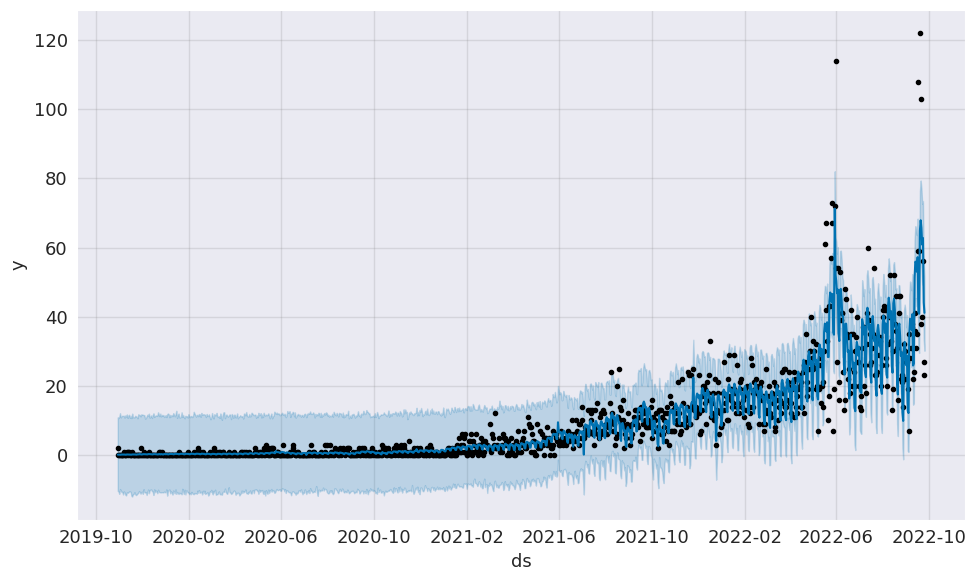

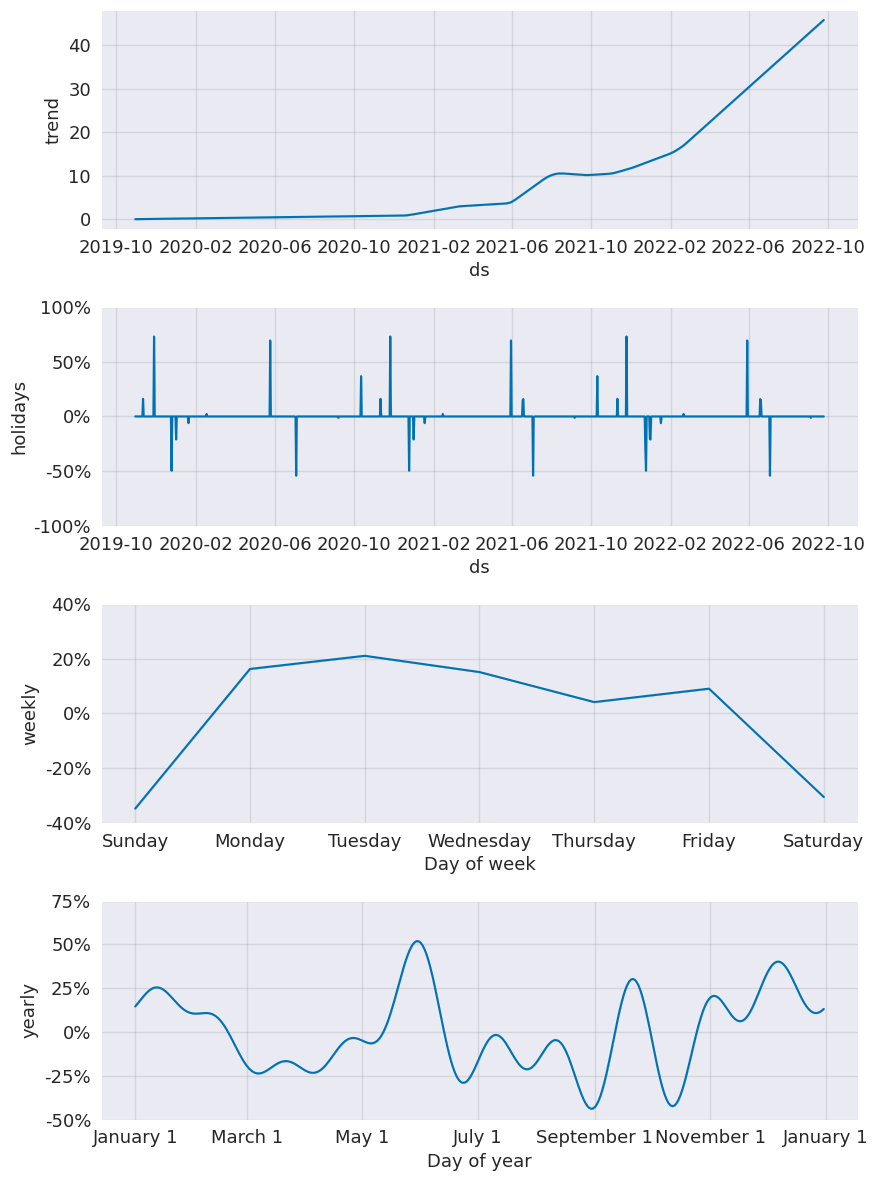

In [ ]:
data = devs_vetted

anomalies = call_prophet(data)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(anomalies)

08:43:30 - cmdstanpy - INFO - Chain [1] start processing
08:43:30 - cmdstanpy - INFO - Chain [1] done processing
08:43:32 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: additive
Interval Width: 0.95
inf 69.99156798094329


08:43:32 - cmdstanpy - INFO - Chain [1] done processing
08:43:39 - cmdstanpy - INFO - Chain [1] start processing
08:43:39 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: additive
Interval Width: 0.95
69.99156798094329 69.38889873937106


08:43:41 - cmdstanpy - INFO - Chain [1] start processing
08:43:41 - cmdstanpy - INFO - Chain [1] done processing
08:43:49 - cmdstanpy - INFO - Chain [1] start processing
08:43:49 - cmdstanpy - INFO - Chain [1] done processing
08:43:51 - cmdstanpy - INFO - Chain [1] start processing
08:43:51 - cmdstanpy - INFO - Chain [1] done processing
08:43:59 - cmdstanpy - INFO - Chain [1] start processing
08:43:59 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
69.38889873937106 69.1119829936621


08:44:01 - cmdstanpy - INFO - Chain [1] start processing
08:44:01 - cmdstanpy - INFO - Chain [1] done processing
08:44:09 - cmdstanpy - INFO - Chain [1] start processing
08:44:09 - cmdstanpy - INFO - Chain [1] done processing
08:44:11 - cmdstanpy - INFO - Chain [1] start processing
08:44:11 - cmdstanpy - INFO - Chain [1] done processing
08:44:19 - cmdstanpy - INFO - Chain [1] start processing
08:44:19 - cmdstanpy - INFO - Chain [1] done processing
08:44:21 - cmdstanpy - INFO - Chain [1] start processing
08:44:21 - cmdstanpy - INFO - Chain [1] done processing
08:44:29 - cmdstanpy - INFO - Chain [1] start processing
08:44:29 - cmdstanpy - INFO - Chain [1] done processing
08:44:31 - cmdstanpy - INFO - Chain [1] start processing
08:44:31 - cmdstanpy - INFO - Chain [1] done processing
08:44:38 - cmdstanpy - INFO - Chain [1] start processing
08:44:39 - cmdstanpy - INFO - Chain [1] done processing
08:44:41 - cmdstanpy - INFO - Chain [1] start processing
08:44:41 - cmdstanpy - INFO - Chain [1]

New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: additive
Interval Width: 0.95
69.1119829936621 54.396464876226396


08:44:58 - cmdstanpy - INFO - Chain [1] start processing
08:44:58 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: additive
Interval Width: 0.95
54.396464876226396 53.85916311335747


08:45:00 - cmdstanpy - INFO - Chain [1] start processing
08:45:00 - cmdstanpy - INFO - Chain [1] done processing
08:45:08 - cmdstanpy - INFO - Chain [1] start processing
08:45:08 - cmdstanpy - INFO - Chain [1] done processing
08:45:10 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
53.85916311335747 32.98292404592898


08:45:10 - cmdstanpy - INFO - Chain [1] done processing
08:45:18 - cmdstanpy - INFO - Chain [1] start processing
08:45:18 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
32.98292404592898 31.698183458144083


08:45:20 - cmdstanpy - INFO - Chain [1] start processing
08:45:20 - cmdstanpy - INFO - Chain [1] done processing
08:45:28 - cmdstanpy - INFO - Chain [1] start processing
08:45:28 - cmdstanpy - INFO - Chain [1] done processing
08:45:35 - cmdstanpy - INFO - Chain [1] start processing
08:45:35 - cmdstanpy - INFO - Chain [1] done processing
08:45:43 - cmdstanpy - INFO - Chain [1] start processing
08:45:43 - cmdstanpy - INFO - Chain [1] done processing
08:45:50 - cmdstanpy - INFO - Chain [1] start processing
08:45:50 - cmdstanpy - INFO - Chain [1] done processing
08:45:58 - cmdstanpy - INFO - Chain [1] start processing
08:45:58 - cmdstanpy - INFO - Chain [1] done processing
08:46:05 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
31.698183458144083 30.825868315595493


08:46:06 - cmdstanpy - INFO - Chain [1] done processing
08:46:13 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
30.825868315595493 30.316670627344013


08:46:14 - cmdstanpy - INFO - Chain [1] done processing
08:46:21 - cmdstanpy - INFO - Chain [1] start processing
08:46:21 - cmdstanpy - INFO - Chain [1] done processing
08:46:29 - cmdstanpy - INFO - Chain [1] start processing
08:46:29 - cmdstanpy - INFO - Chain [1] done processing
08:46:36 - cmdstanpy - INFO - Chain [1] start processing
08:46:36 - cmdstanpy - INFO - Chain [1] done processing
08:46:44 - cmdstanpy - INFO - Chain [1] start processing
08:46:44 - cmdstanpy - INFO - Chain [1] done processing
08:46:51 - cmdstanpy - INFO - Chain [1] start processing
08:46:51 - cmdstanpy - INFO - Chain [1] done processing
08:46:58 - cmdstanpy - INFO - Chain [1] start processing
08:46:58 - cmdstanpy - INFO - Chain [1] done processing
08:47:05 - cmdstanpy - INFO - Chain [1] start processing
08:47:05 - cmdstanpy - INFO - Chain [1] done processing
08:47:13 - cmdstanpy - INFO - Chain [1] start processing
08:47:13 - cmdstanpy - INFO - Chain [1] done processing
08:47:20 - cmdstanpy - INFO - Chain [1] 

New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
30.316670627344013 28.62831646606975


08:49:04 - cmdstanpy - INFO - Chain [1] done processing
08:49:11 - cmdstanpy - INFO - Chain [1] start processing
08:49:11 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
28.62831646606975 27.97003394763934


08:49:19 - cmdstanpy - INFO - Chain [1] start processing
08:49:19 - cmdstanpy - INFO - Chain [1] done processing
08:49:26 - cmdstanpy - INFO - Chain [1] start processing
08:49:26 - cmdstanpy - INFO - Chain [1] done processing
08:49:33 - cmdstanpy - INFO - Chain [1] start processing
08:49:33 - cmdstanpy - INFO - Chain [1] done processing
08:49:41 - cmdstanpy - INFO - Chain [1] start processing
08:49:41 - cmdstanpy - INFO - Chain [1] done processing
08:49:48 - cmdstanpy - INFO - Chain [1] start processing
08:49:48 - cmdstanpy - INFO - Chain [1] done processing
08:49:56 - cmdstanpy - INFO - Chain [1] start processing
08:49:56 - cmdstanpy - INFO - Chain [1] done processing
08:50:03 - cmdstanpy - INFO - Chain [1] start processing
08:50:03 - cmdstanpy - INFO - Chain [1] done processing
08:50:11 - cmdstanpy - INFO - Chain [1] start processing
08:50:11 - cmdstanpy - INFO - Chain [1] done processing
08:50:19 - cmdstanpy - INFO - Chain [1] start processing
08:50:19 - cmdstanpy - INFO - Chain [1]

Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95


08:50:26 - cmdstanpy - INFO - Chain [1] done processing


0    922
1     69
Name: anomaly, dtype: int64
The MAE for the model is 17.75412059884422
The MAPE for the model is 2250163862487582.5
The RMSE for the model is 27.97003394763934
            ds    y        mean        yhat  yhat_lower  yhat_upper  anomaly  \
172 2020-06-02   85   21.285714   20.106476  -34.089313   72.242592        1   
525 2021-05-21  124   59.142857   59.527168    3.220032  107.996607        1   
588 2021-07-23  171   94.285714   89.637086   32.587461  144.241955        1   
612 2021-08-16  178   94.428571  107.043606   52.687948  158.232351        1   
643 2021-09-16   57   67.000000  116.017229   61.794485  171.165497        1   
647 2021-09-20  186   77.285714  119.391100   66.454644  175.439320        1   
648 2021-09-21  234   94.428571  128.003015   72.115544  182.289406        1   
670 2021-10-13   71   79.000000  132.661699   79.244448  189.466611        1   
691 2021-11-03   81   94.428571  158.817282  103.793166  213.586736        1   
692 2021-11-04   82   

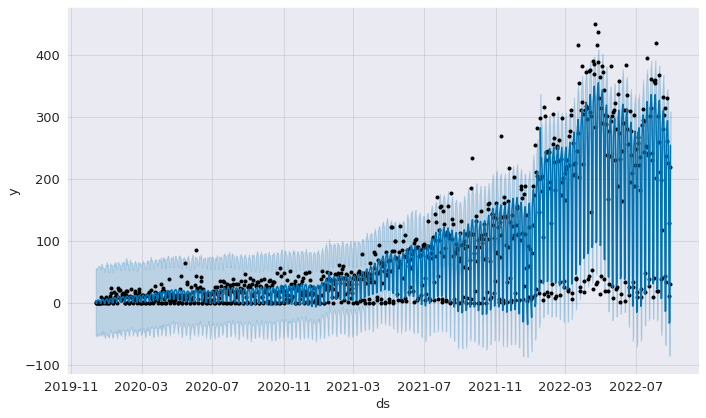

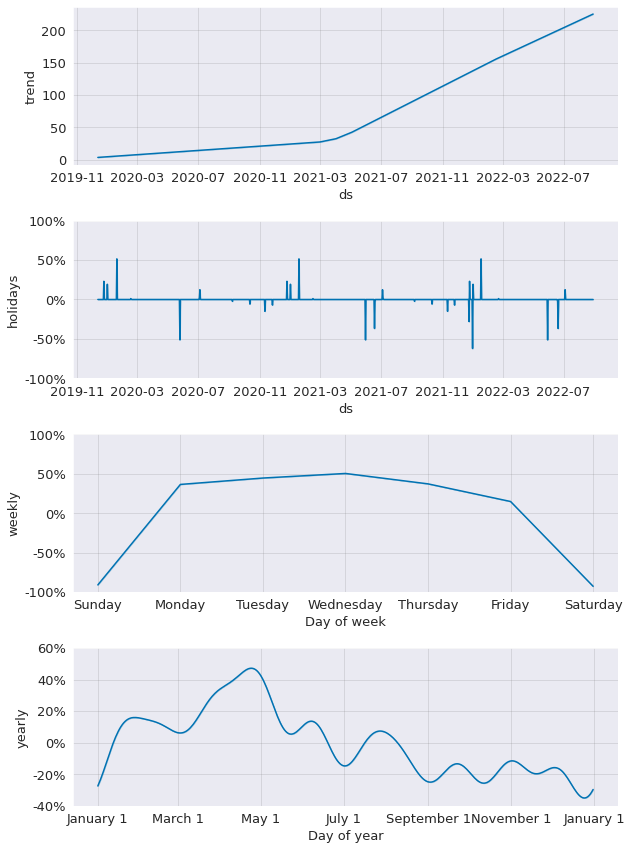

In [ ]:
data = devs_shortlisted

anomalies = call_prophet(data)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(anomalies)

08:50:36 - cmdstanpy - INFO - Chain [1] start processing
08:50:36 - cmdstanpy - INFO - Chain [1] done processing
08:50:39 - cmdstanpy - INFO - Chain [1] start processing
08:50:39 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: additive
Interval Width: 0.95
inf 2.5574464224731717


08:50:47 - cmdstanpy - INFO - Chain [1] start processing
08:50:47 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: False
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: additive
Interval Width: 0.95
2.5574464224731717 2.5312421722801064


08:50:49 - cmdstanpy - INFO - Chain [1] start processing
08:50:49 - cmdstanpy - INFO - Chain [1] done processing
08:50:56 - cmdstanpy - INFO - Chain [1] start processing
08:50:56 - cmdstanpy - INFO - Chain [1] done processing
08:50:59 - cmdstanpy - INFO - Chain [1] start processing
08:50:59 - cmdstanpy - INFO - Chain [1] done processing
08:51:06 - cmdstanpy - INFO - Chain [1] start processing
08:51:06 - cmdstanpy - INFO - Chain [1] done processing
08:51:09 - cmdstanpy - INFO - Chain [1] start processing
08:51:09 - cmdstanpy - INFO - Chain [1] done processing
08:51:16 - cmdstanpy - INFO - Chain [1] start processing
08:51:16 - cmdstanpy - INFO - Chain [1] done processing
08:51:19 - cmdstanpy - INFO - Chain [1] start processing
08:51:19 - cmdstanpy - INFO - Chain [1] done processing
08:51:26 - cmdstanpy - INFO - Chain [1] start processing
08:51:26 - cmdstanpy - INFO - Chain [1] done processing
08:51:28 - cmdstanpy - INFO - Chain [1] start processing
08:51:28 - cmdstanpy - INFO - Chain [1]

New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: additive
Interval Width: 0.95
2.5312421722801064 2.1554897764570904


08:51:58 - cmdstanpy - INFO - Chain [1] done processing
08:52:05 - cmdstanpy - INFO - Chain [1] start processing
08:52:06 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: additive
Interval Width: 0.95
2.1554897764570904 2.1274470558078313


08:52:08 - cmdstanpy - INFO - Chain [1] start processing
08:52:08 - cmdstanpy - INFO - Chain [1] done processing
08:52:16 - cmdstanpy - INFO - Chain [1] start processing
08:52:16 - cmdstanpy - INFO - Chain [1] done processing
08:52:18 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
2.1274470558078313 1.9154967027750962


08:52:18 - cmdstanpy - INFO - Chain [1] done processing
08:52:26 - cmdstanpy - INFO - Chain [1] start processing
08:52:26 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
1.9154967027750962 1.8854496193420134


08:52:28 - cmdstanpy - INFO - Chain [1] start processing
08:52:28 - cmdstanpy - INFO - Chain [1] done processing
08:52:36 - cmdstanpy - INFO - Chain [1] start processing
08:52:36 - cmdstanpy - INFO - Chain [1] done processing
08:52:43 - cmdstanpy - INFO - Chain [1] start processing
08:52:43 - cmdstanpy - INFO - Chain [1] done processing
08:52:51 - cmdstanpy - INFO - Chain [1] start processing
08:52:51 - cmdstanpy - INFO - Chain [1] done processing
08:52:58 - cmdstanpy - INFO - Chain [1] start processing
08:52:58 - cmdstanpy - INFO - Chain [1] done processing
08:53:05 - cmdstanpy - INFO - Chain [1] start processing
08:53:05 - cmdstanpy - INFO - Chain [1] done processing
08:53:13 - cmdstanpy - INFO - Chain [1] start processing
08:53:13 - cmdstanpy - INFO - Chain [1] done processing
08:53:21 - cmdstanpy - INFO - Chain [1] start processing


New:
Daily Seasonality: True
Weekly Seasonality: True
Yearly Seasonality: False
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
1.8854496193420134 1.8849547931199278


08:53:21 - cmdstanpy - INFO - Chain [1] done processing
08:53:28 - cmdstanpy - INFO - Chain [1] start processing
08:53:28 - cmdstanpy - INFO - Chain [1] done processing
08:53:36 - cmdstanpy - INFO - Chain [1] start processing
08:53:36 - cmdstanpy - INFO - Chain [1] done processing
08:53:43 - cmdstanpy - INFO - Chain [1] start processing
08:53:43 - cmdstanpy - INFO - Chain [1] done processing
08:53:51 - cmdstanpy - INFO - Chain [1] start processing
08:53:51 - cmdstanpy - INFO - Chain [1] done processing
08:53:59 - cmdstanpy - INFO - Chain [1] start processing
08:53:59 - cmdstanpy - INFO - Chain [1] done processing
08:54:06 - cmdstanpy - INFO - Chain [1] start processing
08:54:06 - cmdstanpy - INFO - Chain [1] done processing
08:54:13 - cmdstanpy - INFO - Chain [1] start processing
08:54:13 - cmdstanpy - INFO - Chain [1] done processing
08:54:21 - cmdstanpy - INFO - Chain [1] start processing
08:54:21 - cmdstanpy - INFO - Chain [1] done processing
08:54:28 - cmdstanpy - INFO - Chain [1] 

New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: False
Seasonality Mode: multiplicative
Interval Width: 0.95
1.8849547931199278 1.8629343851650084


08:56:15 - cmdstanpy - INFO - Chain [1] done processing
08:56:22 - cmdstanpy - INFO - Chain [1] start processing
08:56:23 - cmdstanpy - INFO - Chain [1] done processing


New:
Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95
1.8629343851650084 1.8395368351940289


08:56:30 - cmdstanpy - INFO - Chain [1] start processing
08:56:30 - cmdstanpy - INFO - Chain [1] done processing
08:56:37 - cmdstanpy - INFO - Chain [1] start processing
08:56:38 - cmdstanpy - INFO - Chain [1] done processing
08:56:45 - cmdstanpy - INFO - Chain [1] start processing
08:56:45 - cmdstanpy - INFO - Chain [1] done processing
08:56:53 - cmdstanpy - INFO - Chain [1] start processing
08:56:53 - cmdstanpy - INFO - Chain [1] done processing
08:57:01 - cmdstanpy - INFO - Chain [1] start processing
08:57:01 - cmdstanpy - INFO - Chain [1] done processing
08:57:08 - cmdstanpy - INFO - Chain [1] start processing
08:57:08 - cmdstanpy - INFO - Chain [1] done processing
08:57:16 - cmdstanpy - INFO - Chain [1] start processing
08:57:16 - cmdstanpy - INFO - Chain [1] done processing
08:57:23 - cmdstanpy - INFO - Chain [1] start processing
08:57:24 - cmdstanpy - INFO - Chain [1] done processing
08:57:31 - cmdstanpy - INFO - Chain [1] start processing
08:57:31 - cmdstanpy - INFO - Chain [1]

Daily Seasonality: False
Weekly Seasonality: True
Yearly Seasonality: True
Holiday Effect: True
Seasonality Mode: multiplicative
Interval Width: 0.95


08:57:39 - cmdstanpy - INFO - Chain [1] done processing


0    968
1     73
Name: anomaly, dtype: int64
The MAE for the model is 1.2256550780531665
The MAPE for the model is 1124105691191086.2
The RMSE for the model is 1.8395368351940289
             ds   y      mean      yhat  yhat_lower  yhat_upper  anomaly  \
204  2020-05-15   6  1.857143  1.007619   -2.750887    4.406325        1   
231  2020-06-11   5  1.000000  1.206768   -2.392641    4.985314        1   
264  2020-07-14   5  1.571429  1.277797   -2.450471    4.883159        1   
321  2020-09-09   9  2.285714  1.335091   -2.208220    5.177869        1   
335  2020-09-23   5  2.142857  1.490675   -2.076388    4.950051        1   
601  2021-06-16   8  3.000000  3.260332   -0.253447    6.858425        1   
602  2021-06-17  10  3.571429  3.350071    0.272394    6.957270        1   
603  2021-06-18   9  4.428571  4.415893    0.913341    8.291238        1   
606  2021-06-21  10  5.571429  3.140816   -0.212301    6.713701        1   
613  2021-06-28   8  2.857143  2.874739   -0.800536    6.354

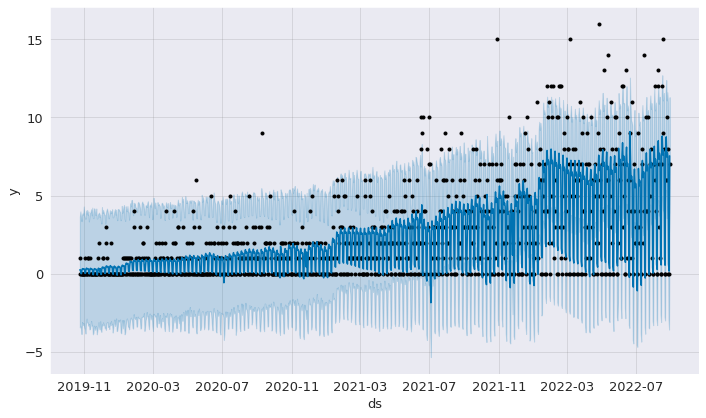

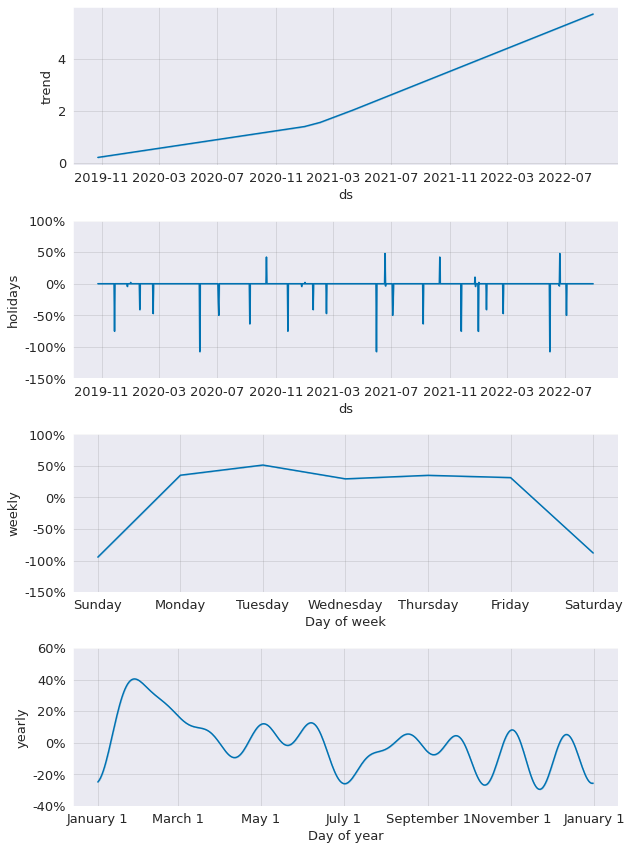

In [ ]:
data = devs_chosen

anomalies = call_prophet(data)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(anomalies)